## Environment Setup
Connecting to backend execution cores:

In [5]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')
view = c[:]
view.activate()

## Intraday Mean Reversion Backtesting Example Code
Backtesting trading strategies is an important financial application. Here we use an Intraday Mean Reversion [online example](http://www.pythonforfinance.net/2017/02/20/intraday-stock-mean-reversion-trading-backtest-in-python/). The dataset is public stock data available from online APIs (e.g. Yahoo).

In [9]:
%%px --block
import pandas as pd
import numpy as np
import h5py
import time
import bodo
from bodo import prange


@bodo.jit(locals={'s_open': bodo.float64[:], 's_high': bodo.float64[:],
        's_low': bodo.float64[:], 's_close': bodo.float64[:],
        's_vol': bodo.float64[:]})
def intraday_mean_revert():
    file_name = "/Users/ehsan/dev/sw/data/stock_data_all_google.hdf5"
    f = h5py.File(file_name, "r")
    sym_list = list(f.keys())
    nsyms = len(sym_list)
    max_num_days = 4000
    all_res = np.zeros(max_num_days)

    t1 = time.time()
    for i in prange(nsyms):
        symbol = sym_list[i]

        s_open = f[symbol+'/Open'][:]
        s_high = f[symbol+'/High'][:]
        s_low = f[symbol+'/Low'][:]
        s_close = f[symbol+'/Close'][:]
        s_vol = f[symbol+'/Volume'][:]
        df = pd.DataFrame({'Open': s_open, 'High': s_high, 'Low': s_low,
                            'Close': s_close, 'Volume': s_vol,})

        #create column to hold our 90 day rolling standard deviation
        df['Stdev'] = df['Close'].rolling(window=90).std()

        #create a column to hold our 20 day moving average
        df['Moving Average'] = df['Close'].rolling(window=20).mean()

        #create a column which holds a TRUE value if the gap down from previous day's low to next
        #day's open is larger than the 90 day rolling standard deviation
        df['Criteria1'] = (df['Open'] - df['Low'].shift(1)) < -df['Stdev']

        #create a column which holds a TRUE value if the opening price of the stock is above the 20 day moving average
        df['Criteria2'] = df['Open'] > df['Moving Average']

        #create a column that holds a TRUE value if both above criteria are also TRUE
        df['BUY'] = df['Criteria1'] & df['Criteria2']

        #calculate daily % return series for stock
        df['Pct Change'] = (df['Close'] - df['Open']) / df['Open']

        #create a strategy return series by using the daily stock returns where the trade criteria above are met
        df['Rets'] = df['Pct Change'][df['BUY'] == True]

        n_days = len(df['Rets'])
        res = np.zeros(max_num_days)
        if n_days:
            res[-n_days:] = df['Rets'].fillna(0).values
        all_res += res

    f.close()
    print(all_res.mean())
    print("execution time:", time.time()-t1)
    return all_res

all_res = intraday_mean_revert()

[stdout:0] 
0.0186685488078326
execution time: 0.2837543950881809


This computation takes 33.9 seconds on Python but only 0.56 seconds on Bodo (60x speedup on 8 cores)

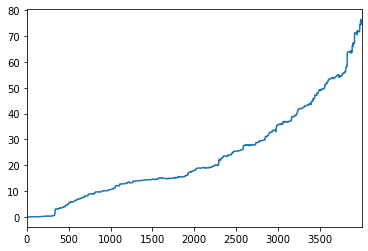

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
results = view['all_res'][0]
pd.Series(results).cumsum().plot()